In [122]:
import numpy as np
import matplotlib.pyplot as plt

from pandas import read_csv

In [123]:
data = read_csv('data/agg/BTC_agg_OI_FR.csv', parse_dates=['timestamp'])
data = data.set_index('timestamp')
data

,Agg Weighted FR,Agg OI
timestamp,,
2020-04-01,-0.039073,6.966046e+08
2020-04-02,0.006521,6.665020e+08
2020-04-03,-0.021530,6.837366e+08
2020-04-04,-0.008062,6.865173e+08
2020-04-05,0.001697,6.757367e+08
...,...,...
2023-12-27,0.029520,3.147515e+09
2023-12-28,0.030703,3.135693e+09
2023-12-29,0.019693,3.065951e+09


Quantile_25: Mean = -0.05584171825000093, Std = 0.003374051073522608, Skew = 0.973966685231782


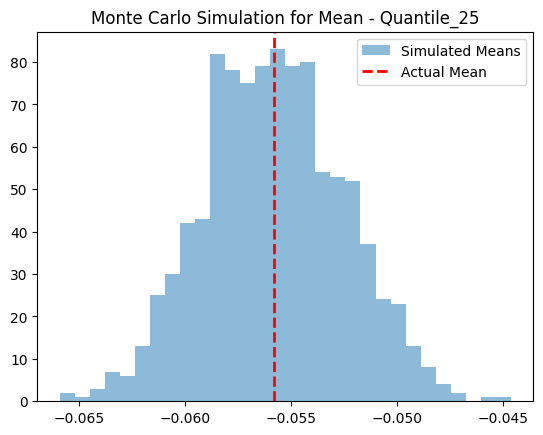

Quantile_50: Mean = -0.044826200341419147, Std = 0.0046529100225651985, Skew = -1.0867023949478414


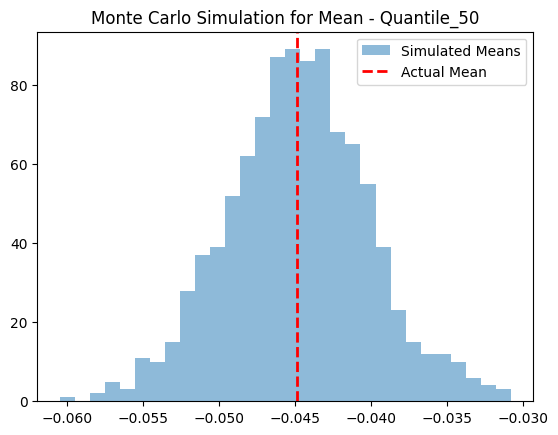

Quantile_75: Mean = -0.038432216849635964, Std = 0.0005892959643794105, Skew = -0.8835005596262147


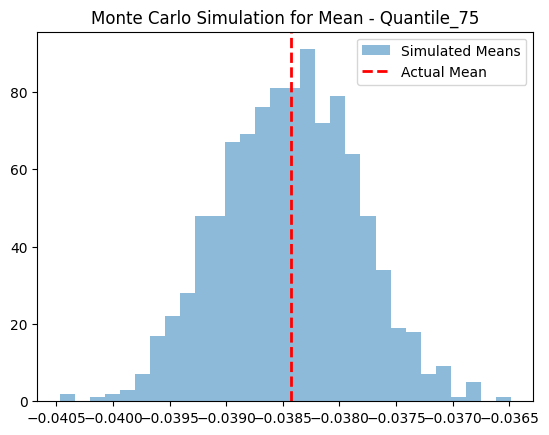

Quantile_95: Mean = 0.010029230014168358, Std = 0.026324996024906157, Skew = 4.042646248106128


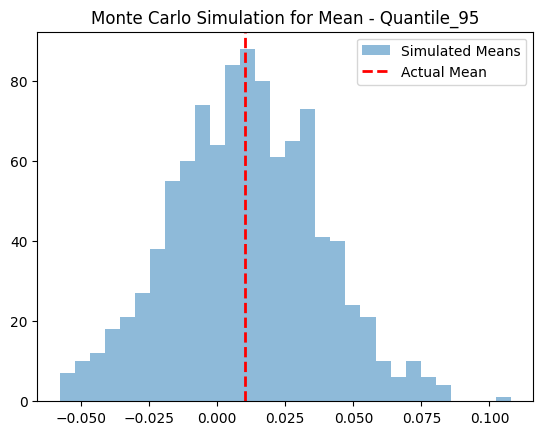

In [124]:
quantiles = [0.25, 0.50, 0.75, 0.95]
quantile_values = np.percentile(data['Agg Weighted FR'], quantiles)

quantile_dfs = {}


for i in range(len(quantiles)):
    if i < len(quantiles) - 1:
        quantile_df = data[(data['Agg Weighted FR'] >= quantile_values[i]) & (data['Agg Weighted FR'] < quantile_values[i+1])]
    else:
        quantile_df = data[data['Agg Weighted FR'] >= quantile_values[i]]

    quantile_dfs[f'Quantile_{int(quantiles[i]*100)}'] = quantile_df


for name, quantile_df in quantile_dfs.items():
    mean_value = quantile_df['Agg Weighted FR'].mean()
    std_value = quantile_df['Agg Weighted FR'].std()
    skew_value = quantile_df['Agg Weighted FR'].skew()

    print(f"{name}: Mean = {mean_value}, Std = {std_value}, Skew = {skew_value}")

    num_simulations = 1000
    simulated_means = np.random.normal(mean_value, std_value, num_simulations)

    plt.hist(simulated_means, bins=30, alpha=0.5, label='Simulated Means')
    plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label='Actual Mean')
    plt.title(f'Monte Carlo Simulation for Mean - {name}')
    plt.legend()
    plt.show()

In [125]:
mean_value = data['Agg Weighted FR'].mean()
std_value = data['Agg Weighted FR'].std()

num_simulations = 1000
simulated_means = np.random.normal(mean_value, std_value, num_simulations)

data['Agg Weighted FR Simulated'] = np.random.choice(simulated_means, len(data))

origin_mean_value = data['Agg Weighted FR'].mean()
origin_std_value = data['Agg Weighted FR'].std()
print(f"Origin Mean = {origin_mean_value}, Origin Std = {origin_std_value}")

simulated_mean_value = data['Agg Weighted FR Simulated'].mean()
simulated_std_value = data['Agg Weighted FR Simulated'].std()
print(f"Simulated Mean = {simulated_mean_value}, Simulated Std = {simulated_std_value}")


Origin Mean = 0.009265286379689128, Origin Std = 0.02742312262004318
Simulated Mean = 0.009147323421328256, Simulated Std = 0.02676040089805173


In [126]:
data

,Agg Weighted FR,Agg OI,Agg Weighted FR Simulated
timestamp,,,
2020-04-01,-0.039073,6.966046e+08,0.073401
2020-04-02,0.006521,6.665020e+08,0.002605
2020-04-03,-0.021530,6.837366e+08,-0.029602
2020-04-04,-0.008062,6.865173e+08,0.002206
2020-04-05,0.001697,6.757367e+08,0.057303
...,...,...,...
2023-12-27,0.029520,3.147515e+09,0.000716
2023-12-28,0.030703,3.135693e+09,0.040657
2023-12-29,0.019693,3.065951e+09,0.041051


In [127]:
fund_data = data.copy()

fund_data['Pos Size 1'] = fund_data['Agg OI'] * 5e-2
fund_data['Pos Size 2'] = fund_data['Agg OI'] * 1e-1

fund_data['Return 1'] = fund_data[f'Pos Size 1'] * fund_data['Agg Weighted FR']
fund_data['Return 2'] = fund_data[f'Pos Size 2'] * fund_data['Agg Weighted FR']

fund_data['Return 1 Simulated'] = fund_data[f'Pos Size 1'] * fund_data['Agg Weighted FR Simulated']
fund_data['Return 2 Simulated'] = fund_data[f'Pos Size 2'] * fund_data['Agg Weighted FR Simulated']

In [128]:
def calculate_profit(pos, kr, fee, sim=False):
    '''
    args:
        pos - position size: 1 or 2
        kr - keep rate: 0.1, 0.2 or 0.5
        fee - fee value in percent
    '''
    fees = kr * fund_data[f'Pos Size {pos}'] * fee / 1e2
    return fund_data[f'Return {pos}'] - fees if not sim else fund_data[f'Return {pos} Simulated'] - fees

In [129]:
origin_profit = calculate_profit(1, 0.1, 0.06)

In [130]:
origin_profit.sum()

2330098531.161789

In [131]:
origin_profit.mean()

1700801.8475633496

<AxesSubplot: xlabel='timestamp'>

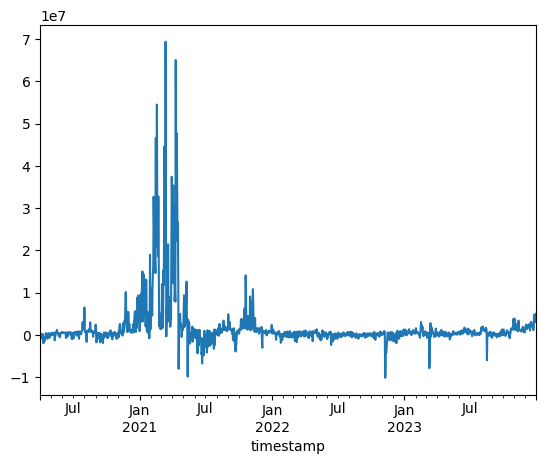

In [132]:
origin_profit.plot()

In [133]:
simulated_profit = calculate_profit(1, 0.1, 0.06, True)

In [134]:
simulated_profit.sum()

1360266122.7576656

In [135]:
simulated_profit.mean()

992894.9801150844

<AxesSubplot: xlabel='timestamp'>

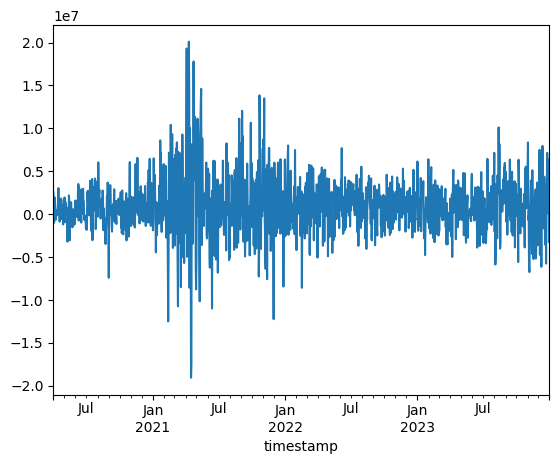

In [136]:
simulated_profit.plot()